In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil

%matplotlib inline
plt.rcParams.update({'font.size': 20})

root_directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/'
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'

In [2]:
def print_mem():
    memory_usage = psutil.Process(os.getpid()).memory_info().rss*10**-9
    print('Current memory usage: {:.2f}GB'.format(memory_usage))
print_mem()

Current memory usage: 0.62GB


In [3]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    plt.figure(figsize=(10,10))
    dendrogram(linkage_matrix, **kwargs)

In [4]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

In [5]:
directory = os.path.join(root_directory,'fly_5','func_0')
brain_path = os.path.join(directory, 'brain_zscored_green.nii')
brain = bbb.load_numpy_brain(brain_path)*1 # this *1 is currently important for some fucking reason
dims = bbb.get_dims(brain)
print('brain shape is x,y,z,t {}'.format(brain.shape))
print_mem()


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 70.81 ms
brain shape is x,y,z,t (77, 128, 49, 4731)
Current memory usage: 9.77GB


In [6]:
t0 = time.time()
one_slice = brain[:,:,8,:].reshape(-1, brain.shape[-1])
print(time.time()-t0)

0.6854856014251709


In [8]:
### For dendrogram
clustering_dir = os.path.join(directory, 'super_voxels')
t0 = time.time()
model = AgglomerativeClustering(distance_threshold=0,
                                n_clusters=None,
                                memory=clustering_dir,
                                linkage='ward')
model = model.fit(one_slice)
print(time.time()-t0)

0.43132996559143066


In [7]:
### To add connectivity constraint if desired ###

from sklearn.feature_extraction.image import grid_to_graph
connectivity = grid_to_graph(77,128)

### For dendrogram
clustering_dir = os.path.join(directory, 'super_voxels')
t0 = time.time()
model = AgglomerativeClustering(distance_threshold=0,
                                n_clusters=None,
                                memory=clustering_dir,
                                linkage='ward',
                                connectivity=connectivity)
model = model.fit(one_slice)
print(time.time()-t0)

0.41019678115844727


In [8]:
ii = itertools.count(one_slice.shape[0])
nodes = [{'node_id': next(ii), 'left': x[0], 'right':x[1]} for x in model.children_]

In [9]:
### Create linkage matrix for dendrogram

counts = np.zeros(model.children_.shape[0])
n_samples = len(model.labels_)
for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([model.children_, model.distances_,
                                  counts]).astype(float)

In [10]:
n_colors = 1000
master_cmap = 'jet'

n_samples = len(nodes) + 1
children_tracker = []

for i in range(len(nodes)):
    left_child = nodes[i]['left']
    right_child = nodes[i]['right']
    num_left_children = 0
    num_right_children = 0
    children_tracker.append({'children': [], 'engulfed_nodes': [i]})
        
    # LEFT CHILD
    if left_child < n_samples:
        children_tracker[-1]['children'].extend([left_child])
    else:
        index = left_child - n_samples
        children_tracker[-1]['children'].extend(children_tracker[index]['children'])
        num_left_children = len(children_tracker[index]['children'])
        
        children_tracker[-1]['engulfed_nodes'].extend(children_tracker[index]['engulfed_nodes'])
    
    # RIGHT CHILD
    if right_child < n_samples:
        children_tracker[-1]['children'].extend([right_child])
    else:
        index = right_child - n_samples
        children_tracker[-1]['children'].extend(children_tracker[index]['children'])
        num_right_children = len(children_tracker[index]['children'])
        
        children_tracker[-1]['engulfed_nodes'].extend(children_tracker[index]['engulfed_nodes'])
        
    # ASSIGN COLOR
    if right_child < n_samples and left_child < n_samples:
        children_tracker[-1]['color'] = random.randint(1, n_colors-1)
    else:
        if num_right_children > num_left_children:
            index = right_child - n_samples
            children_tracker[-1]['color'] = children_tracker[index]['color']
        else:
            index = left_child - n_samples
            children_tracker[-1]['color'] = children_tracker[index]['color']
            
# CREATE BRAIN COLORS OVER TIME

brain_colored = np.zeros((n_samples,n_samples))

for i in range(len(nodes)):
    brain_colored[i+1,:] = brain_colored[i,:]
    brain_colored[i+1,:][children_tracker[i]['children']] = children_tracker[i]['color']
    
brain_colored_toplot = np.reshape(brain_colored, (9856,77,128))
brain_colored_toplot[brain_colored_toplot == 0] = 'nan'
print(brain_colored_toplot.shape)

# CREATE DENDROGRAM COLORS OVER TIME
# here, when a node gets a color, I want all of it's children to get that same color
# need a way to track which nodes were engulfed in other nodes

dendrogram_colored = np.zeros((n_samples,n_samples))

for i in range(len(nodes)):
    dendrogram_colored[i+1,:] = dendrogram_colored[i,:]
    dendrogram_colored[i+1,:][children_tracker[i]['engulfed_nodes']] = children_tracker[i]['color'] # give new node color
    
dendrogram_colored = dendrogram_colored.astype(int)
print(dendrogram_colored.shape)

(9856, 77, 128)
(9856, 9856)


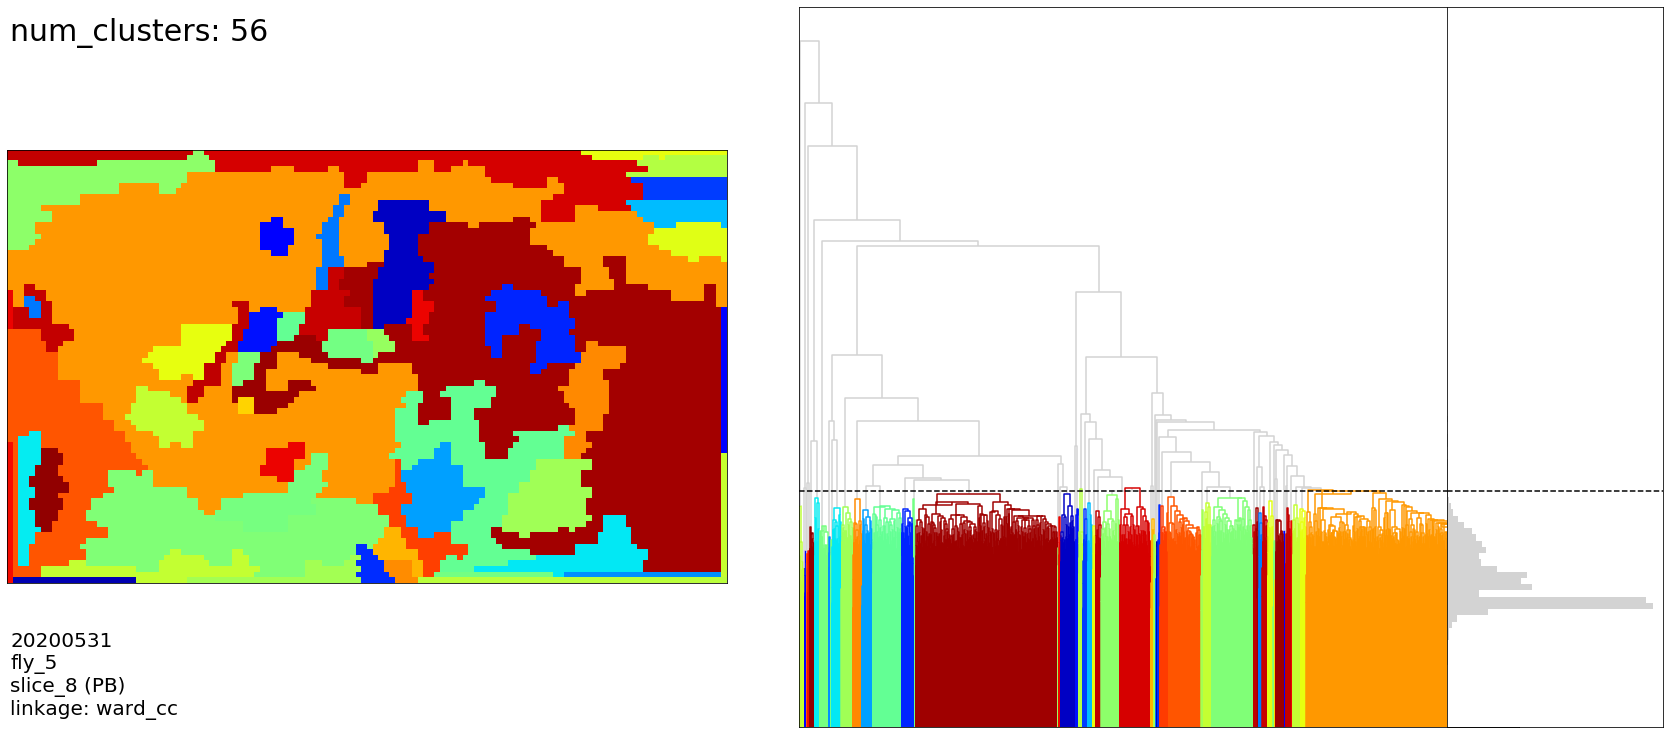

In [14]:
fig = plt.figure(figsize=(10,10))
background_color = '#D3D3D3'

timepoint = 9800

ax_brain = fig.add_axes([0, 0, 1, 1])
ax_brain.imshow(brain_colored_toplot[timepoint,:,:],vmin=0,vmax=n_colors,cmap=master_cmap)
ax_brain.get_xaxis().set_visible(False)
ax_brain.get_yaxis().set_visible(False)
ax_brain.set_facecolor(background_color)

plt.text(0,-20,'num_clusters: {}'.format(n_samples-timepoint), fontsize=30)
plt.text(0,100,'{}\nfly_5\nslice_8 (PB)\nlinkage: ward_cc'.format(time.strftime("%Y%m%d")),fontsize=20)


cmap = cm.Greys(np.linspace(0, 1, n_samples))
throwaway_colors = [mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap]

cmap = getattr(cm, master_cmap)(np.linspace(0, 1, n_colors)) # make the n_colors possible colors in rgba
temp_colors = cmap[dendrogram_colored[timepoint,:],:] # index into these colors using cluster color_ids
true_colors = [mpl.colors.rgb2hex(rgb[:3]) for rgb in temp_colors] # convert to hex

colors = throwaway_colors + true_colors # add throwaway colors to frontend
colors[n_samples+timepoint:] = [background_color]*(n_samples-timepoint) # add grey to non-clusted samples

ax_dendrogram = fig.add_axes([1.1, 0, 1, 1])
ax_dendrogram.get_xaxis().set_visible(False)
ax_dendrogram.get_yaxis().set_visible(False)
dendrogram(linkage_matrix,
           truncate_mode=None,
           p=10000,
           color_threshold=None,
           link_color_func=lambda x: colors[x],
           no_labels=True,
           distance_sort=True);
try:
    plt.axhline(linkage_matrix[timepoint,2],color='k',linestyle='--')
except:
    print('axhline failed')
    

ax_dend_hist = fig.add_axes([2, 0, .3, 1],sharey=ax_dendrogram)
ax_dend_hist.hist(linkage_matrix[:,2],bins=100,orientation='horizontal',color=background_color);
try:
    ax_dend_hist.axhline(linkage_matrix[timepoint,2],color='k',linestyle='--')
except:
    print('axhline failed')
ax_dend_hist.get_xaxis().set_visible(False)
ax_dend_hist.get_yaxis().set_visible(False)

In [15]:
save_path = os.path.join(clustering_dir, 'movies', 'jpeg_20200531_ward_cc')
os.mkdir(save_path)

In [16]:
save_path

'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_5/func_0/super_voxels/movies/jpeg_20200531_ward_cc'

In [ ]:
# VIDEOLOOP
fig = plt.figure(figsize=(10,10))
background_color = '#D3D3D3'

for timepoint in range(n_samples):
    t0=time.time()
    ax_brain = fig.add_axes([0, 0, 1, 1])
    ax_brain.imshow(brain_colored_toplot[timepoint,:,:],vmin=0,vmax=n_colors,cmap=master_cmap)
    ax_brain.get_xaxis().set_visible(False)
    ax_brain.get_yaxis().set_visible(False)
    ax_brain.set_facecolor(background_color)

    plt.text(0,-20,'num_clusters: {}'.format(n_samples-timepoint), fontsize=30)
    plt.text(0,100,'{}\nfly_5\nslice_8 (PB)\nlinkage: ward_cc'.format(time.strftime("%Y%m%d")),fontsize=20)

    cmap = cm.Greys(np.linspace(0, 1, n_samples))
    throwaway_colors = [mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap]

    cmap = getattr(cm, master_cmap)(np.linspace(0, 1, n_colors)) # make the n_colors possible colors in rgba
    temp_colors = cmap[dendrogram_colored[timepoint,:],:] # index into these colors using cluster color_ids
    true_colors = [mpl.colors.rgb2hex(rgb[:3]) for rgb in temp_colors] # convert to hex

    colors = throwaway_colors + true_colors # add throwaway colors to frontend
    colors[n_samples+timepoint:] = [background_color]*(n_samples-timepoint) # add grey to non-clusted samples

    ax_dendrogram = fig.add_axes([1.1, 0, 1, 1])
    ax_dendrogram.get_xaxis().set_visible(False)
    ax_dendrogram.get_yaxis().set_visible(False)
    dendrogram(linkage_matrix,
               truncate_mode=None,
               p=10000,
               color_threshold=None,
               link_color_func=lambda x: colors[x],
               no_labels=True,
               distance_sort=True);
    try:
        plt.axhline(linkage_matrix[timepoint,2],color='k',linestyle='--')
    except:
        print('axhline failed')


    ax_dend_hist = fig.add_axes([2, 0, .3, 1],sharey=ax_dendrogram)
    ax_dend_hist.hist(linkage_matrix[:,2],bins=100,orientation='horizontal',color=background_color);
    try:
        ax_dend_hist.axhline(linkage_matrix[timepoint,2],color='k',linestyle='--')
    except:
        print('axhline failed')
    ax_dend_hist.get_xaxis().set_visible(False)
    ax_dend_hist.get_yaxis().set_visible(False)
    
    fname = os.path.join(save_path, '{0:05d}.png'.format(timepoint))
    plt.savefig(fname,dpi=100,bbox_inches='tight')
    fig.clf()
    print('frame {}, {}'.format(timepoint, time.time()-t0))

frame 0, 2.0534238815307617
frame 1, 1.9251887798309326
frame 2, 2.0040783882141113
frame 3, 1.9977643489837646
frame 4, 2.0010135173797607
frame 5, 2.0601449012756348
frame 6, 2.05497407913208
frame 7, 2.042874574661255
frame 8, 2.0960423946380615
frame 9, 2.063509464263916
frame 10, 2.103346586227417
frame 11, 2.0511441230773926
frame 12, 2.041116237640381
frame 13, 2.0736658573150635
frame 14, 2.0501863956451416
frame 15, 2.0718939304351807
frame 16, 2.0569634437561035
frame 17, 2.0804336071014404
frame 18, 2.050004720687866
frame 19, 2.0326948165893555
frame 20, 2.1306965351104736
frame 21, 2.03717041015625
frame 22, 2.034501314163208
frame 23, 2.0033440589904785
frame 24, 2.004363536834717
frame 25, 2.041151762008667
frame 26, 2.011998414993286
frame 27, 2.029045820236206
frame 28, 2.029601812362671
frame 29, 2.0378952026367188
frame 30, 2.0387392044067383
frame 31, 2.020052909851074
frame 32, 2.032304525375366
frame 33, 2.063385009765625
frame 34, 2.0497868061065674
frame 35, 2.0